In [ ]:
# Libraries
!pip install pydub
!apt-get install ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
pip install imbalanced-learn

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import librosa
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow_datasets.core import lazy_builder_import
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt
from keras import backend as K
from keras.optimizers import Adam
from keras.metrics import Precision, Recall
from sklearn.metrics import accuracy_score, f1_score
import zipfile
import os
import glob
import random
import soundfile as sf
from pydub import AudioSegment
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

In [ ]:
# determine path file and extract data in voice_data folder
zip_files = ["/content/records.zip", "/content/records2.zip", "/content/records3.zip", "/content/records4.zip"]

extract_folder = "students_data"
if not os.path.exists(extract_folder):
    os.makedirs(extract_folder)
# Decompress files
for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_folder)
        print(f"Extracted {zip_file} to {extract_folder}")

Extracted /content/records.zip to students_data
Extracted /content/records2.zip to students_data
Extracted /content/records3.zip to students_data
Extracted /content/records4.zip to students_data


In [ ]:
# ensure the number of files
students_dirs = ["/content/students_data/records", "/content/students_data/records2", "/content/students_data/records3", "/content/students_data/records4"]

students_files = []
for student_dir in students_dirs:
    student_files = [os.path.join(student_dir, file) for file in os.listdir(student_dir) if file.endswith('.wav')]
    students_files.append(student_files)



for i, student_files in enumerate(students_files, start=1):
    print(f"Number of files for student {i}: {len(student_files)}")

Number of files for student 1: 20
Number of files for student 2: 20
Number of files for student 3: 20
Number of files for student 4: 20


In [ ]:
# ensure that all files have same frequency
folder_paths = [
    '/content/students_data/records',
    '/content/students_data/records2',
    '/content/students_data/records3',
    '/content/students_data/records4'

]

for folder in folder_paths:
    print(f"Checking files in {folder}:")
    for file in os.listdir(folder):
        if file.endswith('.wav'):
            file_path = os.path.join(folder, file)
            try:

                audio_data, sr = sf.read(file_path)
                print(f"File {file_path} is valid with sample rate: {sr} Hz")
            except Exception as e:
                print(f"Error opening {file_path}: {e}")
        else:
            print(f"File {file} is not a .wav file.")

Checking files in /content/students_data/records:
File /content/students_data/records/rec5.wav is valid with sample rate: 48000 Hz
File /content/students_data/records/rec16.wav is valid with sample rate: 48000 Hz
File /content/students_data/records/rec11.wav is valid with sample rate: 48000 Hz
File /content/students_data/records/rec2.wav is valid with sample rate: 48000 Hz
File /content/students_data/records/rec12.wav is valid with sample rate: 48000 Hz
File /content/students_data/records/rec6.wav is valid with sample rate: 48000 Hz
File /content/students_data/records/rec4.wav is valid with sample rate: 48000 Hz
File /content/students_data/records/rec8.wav is valid with sample rate: 48000 Hz
File /content/students_data/records/rec18.wav is valid with sample rate: 48000 Hz
File /content/students_data/records/rec10.wav is valid with sample rate: 48000 Hz
File /content/students_data/records/rec20.wav is valid with sample rate: 48000 Hz
File /content/students_data/records/rec17.wav is vali

In [ ]:

audio_files = []
for root, dirs, files in os.walk(extract_folder):
    for file in files:
        if file.endswith(".wav"):
            audio_files.append(os.path.join(root, file))


In [ ]:

fixed_length = 48000

def extract_mfcc(file_path, num_mfcc=15):
    y, sr = librosa.load(file_path, sr=48000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=num_mfcc)
    return np.mean(mfcc, axis=1)


In [ ]:

audio_data = []
for file in audio_files:
    mfcc_features = extract_mfcc(file)
    audio_data.append(mfcc_features)

audio_data = np.array(audio_data)


In [ ]:

labels = []
for i in range(len(audio_data)):
    labels.append(i % 4)

train_data = audio_data[:len(audio_data)//2]
val_data = audio_data[len(audio_data)//2:len(audio_data)*3//4]
test_data = audio_data[len(audio_data)*3//4:]

train_labels = labels[:len(train_data)]
val_labels = labels[len(train_data):len(train_data) + len(val_data)]
test_labels = labels[len(train_data) + len(val_data):]


print(f"Train labels: {train_labels[:10]}")
print(f"Validation labels: {val_labels[:10]}")
print(f"Test labels: {test_labels[:10]}")

Train labels: [0, 1, 2, 3, 0, 1, 2, 3, 0, 1]
Validation labels: [0, 1, 2, 3, 0, 1, 2, 3, 0, 1]
Test labels: [0, 1, 2, 3, 0, 1, 2, 3, 0, 1]


In [ ]:
# Make pairs for training
def make_pairs(x, y):
    num_classes = max(y) + 1
    digit_indices = [np.where(np.atleast_1d(y) == i)[0] for i in range(num_classes)]

    pairs = []
    labels = []

    for idx1 in range(len(x)):

        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(digit_indices[label1])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [0]


        label2 = random.randint(0, num_classes - 1)
        while label2 == label1:
            label2 = random.randint(0, num_classes - 1)

        idx2 = random.choice(digit_indices[label2])
        x2 = x[idx2]

        pairs += [[x1, x2]]
        labels += [1]

    return np.array(pairs), np.array(labels).astype("float32")


In [ ]:

# Make train pairs
pairs_train, labels_train = make_pairs(train_data, train_labels)

# Make validation pairs
pairs_val, labels_val = make_pairs(val_data, val_labels)

# Make test pairs
pairs_test, labels_test = make_pairs(test_data, test_labels)
print(f"Number of pairs in train: {len(pairs_train)}")

print(f"Number of pairs in validation: {len(pairs_val)}")

print(f"Number of pairs in test: {len(pairs_test)}")

Number of pairs in train: 80
Number of pairs in validation: 40
Number of pairs in test: 40


In [ ]:
print(f"Shape of train pairs: {pairs_train.shape}")
print(f"Shape of validation pairs: {pairs_val.shape}")
print(f"Shape of test pairs: {pairs_test.shape}")


Shape of train pairs: (80, 2, 15)
Shape of validation pairs: (40, 2, 15)
Shape of test pairs: (40, 2, 15)


In [ ]:
print(f"First 10 labels in train: {labels_train[:10]}")
print(f"First 10 labels in validation: {labels_val[:10]}")
print(f"First 10 labels in test: {labels_test[:10]}")

First 10 labels in train: [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
First 10 labels in validation: [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]
First 10 labels in test: [0. 1. 0. 1. 0. 1. 0. 1. 0. 1.]


In [ ]:

# Split the training pairs
x_train_1 = pairs_train[:, 0]
x_train_2 = pairs_train[:, 1]

# Split the validation pairs
x_val_1 = pairs_val[:, 0]
x_val_2 = pairs_val[:, 1]

# Split the test pairs
x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]

In [ ]:
print(f"Shape of x_train_1: {x_train_1.shape}")
print(f"Shape of x_train_2: {x_train_2.shape}")
print(f"Shape of x_val_1: {x_val_1.shape}")
print(f"Shape of x_val_2: {x_val_2.shape}")
print(f"Shape of x_test_1: {x_test_1.shape}")
print(f"Shape of x_test_2: {x_test_2.shape}")


Shape of x_train_1: (80, 15)
Shape of x_train_2: (80, 15)
Shape of x_val_1: (40, 15)
Shape of x_val_2: (40, 15)
Shape of x_test_1: (40, 15)
Shape of x_test_2: (40, 15)


In [ ]:
from tensorflow.keras import backend as K

def cosine_distance(vectors):
    x, y = vectors
    cosine = K.sum(x * y, axis=1, keepdims=True)
    norm_x = K.sqrt(K.sum(K.square(x), axis=1, keepdims=True))
    norm_y = K.sqrt(K.sum(K.square(y), axis=1, keepdims=True))
    return cosine / (norm_x * norm_y)

In [ ]:

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)

In [ ]:
from tensorflow.keras import regularizers


input = keras.layers.Input((15,))
x = layers.BatchNormalization()(input)
x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.2)(x)
embedding_network = keras.Model(input, x)


input_1 = keras.layers.Input((15,))
input_2 = keras.layers.Input((15,))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)


merge_layer = layers.Lambda(cosine_distance, output_shape=(1,))([tower_1, tower_2])
normal_layer = layers.BatchNormalization()(merge_layer)
output_layer = layers.Dense(1, activation="sigmoid")(normal_layer)


siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)




In [ ]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'."""

    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss."""


        square_pred = tf.square(y_pred)


        margin_square = tf.square(tf.maximum(margin - y_pred, 0))


        loss_value = tf.reduce_mean((1 - y_true) * square_pred + y_true * margin_square)

        return loss_value

    return contrastive_loss

In [ ]:
siamese.compile(optimizer="adam", loss=loss(margin=1), metrics=["accuracy", f1_score])


In [ ]:
siamese.summary()

Model: "functional_39"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_58            │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_59            │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_38             │ (None, 32)             │          3,164 │ input_layer_58[0][0],  │
│ (Functional)              │                        │                │ input_layer_59[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_19 (Lambda)        │ (None, 1)              │              0 │ functional_38[0][0],   │
│                           │                        │                │ functional_38[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 1)              │              4 │ lambda_19[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_59 (Dense)          │ (None, 1)              │              2 │ batch_normalization_3… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,170 (12.38 KB)

 Trainable params: 3,138 (12.26 KB)

 Non-trainable params: 32 (128.00 B)

In [ ]:
history = siamese.fit([x_train_1, x_train_2], labels_train,
                      validation_data=([x_val_1, x_val_2], labels_val),
                      epochs=100, batch_size=32)


Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.4930 - f1_score: 0.2949 - loss: 0.9479 - val_accuracy: 0.5000 - val_f1_score: 0.5000 - val_loss: 0.9382
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5781 - f1_score: 0.3010 - loss: 0.9071 - val_accuracy: 0.5000 - val_f1_score: 0.5000 - val_loss: 0.9264
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4602 - f1_score: 0.3210 - loss: 0.9318 - val_accuracy: 0.5000 - val_f1_score: 0.5000 - val_loss: 0.9149
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4891 - f1_score: 0.2958 - loss: 0.9051 - val_accuracy: 0.5000 - val_f1_score: 0.5000 - val_loss: 0.9039
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5305 - f1_score: 0.2999 - loss: 0.8843 - val_accuracy: 0.5000 - val_f1_score: 0.5000 - val_loss: 0.8930
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6000 - f1_score: 0.2910 - loss: 0.8616 - val_accuracy: 0.5000 - val_f1_score: 0.5000 - val_loss

In [ ]:

def predict_similarity(model, reference_sample, test_sample):

    reference_sample = np.expand_dims(reference_sample, axis=0)
    test_sample = np.expand_dims(test_sample, axis=0)

    similarity_score = model.predict([reference_sample, test_sample])[0][0]

    print(f"Similarity Score: {similarity_score:.4f}")
    if similarity_score > 0.5:
        print("The samples are considered similar.")
    else:
        print("The samples are considered not similar.")


reference_sample = x_val_1[0]
test_sample = x_val_2[1]


predict_similarity(siamese, reference_sample, test_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Similarity Score: 0.7599
The samples are considered similar.


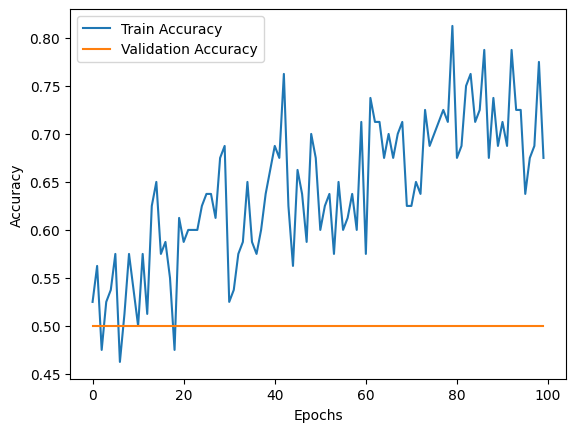

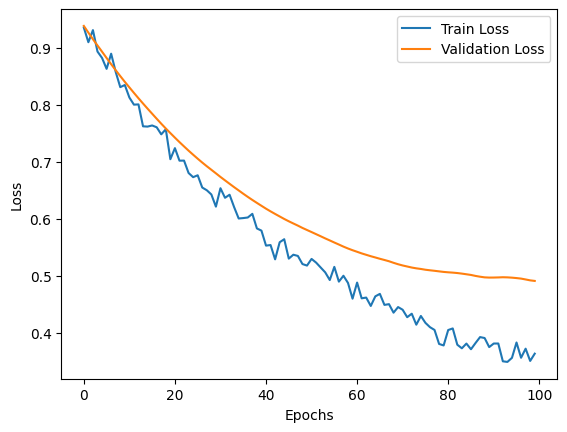

In [ ]:

plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


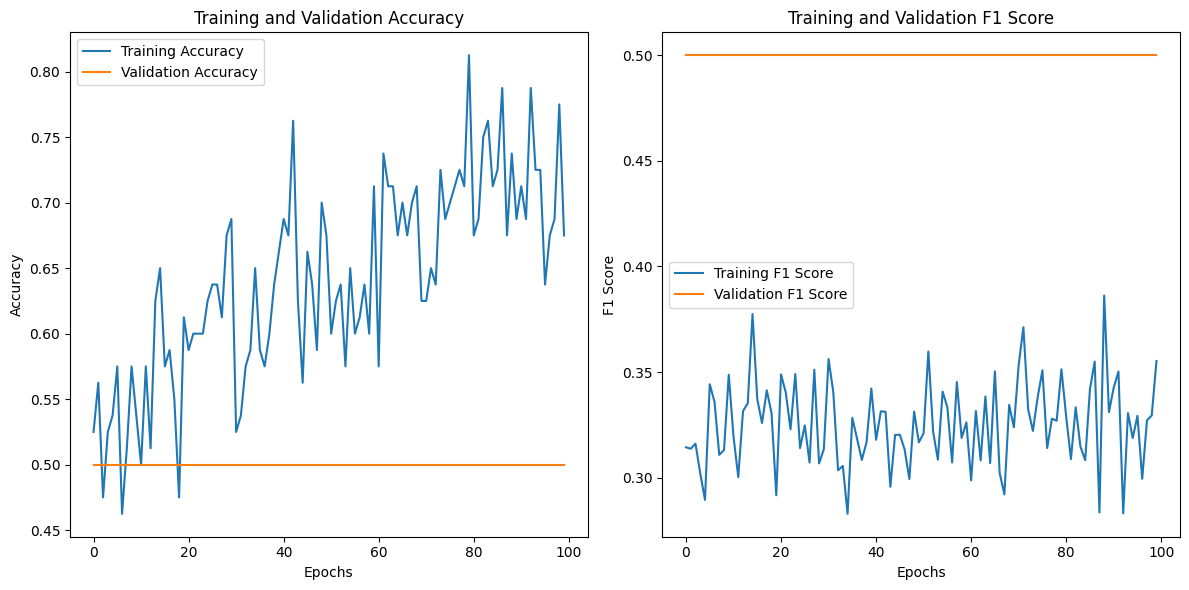

In [ ]:
import matplotlib.pyplot as plt


def visualize(history):

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    f1_score = history.history['f1_score']
    val_f1_score = history.history['val_f1_score']


    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(f1_score, label='Training F1 Score')
    plt.plot(val_f1_score, label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()


    plt.tight_layout()
    plt.show()


visualize(history)
